# S1 Multiplicity
.... background and bullshit

In [1]:
import datetime

In [2]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-03-29 15:53:03


In [3]:
from __future__ import print_function
import sys
import os
from glob import glob
from time import time

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math

In [5]:
from invisible_cities.database import load_db
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions_c as cpf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.pmaps_functions as pmf

In [6]:
from invisible_cities.reco.pmap_io import pmap_writer, S12, S2Si

from invisible_cities.core.configure import configure, print_configuration

from invisible_cities.core.system_of_units_c import units
from invisible_cities.cities.base_cities import PmapCity, SensorParams
from invisible_cities.cities.base_cities import S12Params as S12P

In [7]:
from invisible_cities.core.core_functions import define_window
from invisible_cities.core.core_functions import lrange
from collections import namedtuple

In [8]:
from invisible_cities.reco.params import S12Params, ThresholdParams, CalibratedSum, PMaps,\
                                         SensorParams, CalibParams, PmapParams, CalibratedPMT, S1PMaps

In [9]:
from matplotlib.figure import Figure

In [10]:
%load_ext Cython

In [11]:
from event_pmaps import compare_S1_ext

### Input

In [12]:
run_number=3392
#run_number=0

In [13]:
ic_data = os.path.join(os.environ['IC_DATA'])
files  = glob(ic_data + 'LSC/' + str(run_number) + '/' +  'dst_waves.gdcsnext.*_3392.root.h5')
#files  = [ic_data + 'Montecarlo/' + 'dst_NEXT_v0_08_09_Kr_ACTIVE_0_0_7bar_RWF_10000.root.h5']

In [14]:
print(files)

['/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.000_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.001_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.002_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.003_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.004_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.005_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.006_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.007_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.008_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.009_3392.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3392/dst_waves.gdcsnext.010_3392.root.h5']


### pmtrwf and sipmrwf vectors

To get vectors use **get_vectors(file)** in tbl_functions

In [15]:
def _calib_vectors(self):
        """Provisional fix for calib vectors"""
        channel_id = np.array([0,1,4,5,8,18,22,23,26,27,30])
        coeff_blr = np.array([1.61,1.62,1.61,1.61,1.61,
                          0.8,0.8,0.8,0.8,0.8,1.60,
                          1.0]) * 0.001
        coeff_c = np.array([2.94,2.75,3.09,2.81,2.88,
                        1.,1.,1.,1.,1.,2.76,
                        1.0]) * 1e-6
        adc_to_pes = np.array([25.17,22.15,33.57,23.88,21.55,
                           26.49,25.39,27.74,23.78,20.83,26.56,
                           0.])
        pmt_active = list(range(11))

        DataSiPM = load_db.DataSiPM()
        self.P   = CalibVectors(channel_id = channel_id,
                                coeff_blr  = coeff_blr,
                                coeff_c    = coeff_c,
                                adc_to_pes_pmt = adc_to_pes,
                                adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                                pmt_active  = pmt_active)

### S1 multiplicity

In [16]:
DataPMT = load_db.DataPMT(run_number)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
coeff_c    = abs(DataPMT.coeff_c.values)
coeff_blr  = abs(DataPMT.coeff_blr.values)
DataSiPM   = load_db.DataSiPM()
adc_to_pes_sipm = DataSiPM.adc_to_pes.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [29]:
multiplicity = []
energies = []

Ms = []

no_m_ev = []
#no_m_s1 = []

for f in files:
    
    with tb.open_file(f, 'r') as h5rwf:

        pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
        NEVT, NPMT, PMTWL = pmtrwf.shape
        NEVT, NSIPM, SIPMWL = sipmrwf.shape
        
        # QUICK FIX
        IDs = np.append(h5rwf.root.Sensors.DataPMT[:]['sensorID'], 13)
        order = np.argsort(IDs)
        pmtrwf_o = np.array(pmtrwf)[:, order]

        for event in range(NEVT):
            if len(energies) >= 1500: break

            # Get cwf csum_mau
            RWF = pmtrwf_o[event]
            
            CWF = blr.deconv_pmt(RWF,
                                 coeff_c,
                                 coeff_blr,
                                 pmt_active,
                                 n_baseline  = 48000,
                                 thr_trigger = 5)

            CAL_PMT, CAL_PMT_MAU = cpf.calibrated_pmt_mau(
                                   CWF,
                                   adc_to_pes,
                                   pmt_active = pmt_active,
                                   n_MAU   = 100,
                                   thr_MAU =   3)
            csum, csum_mau = cpf.calibrated_pmt_sum(CWF,adc_to_pes, pmt_active)

            # Find s1s ## SET tmin and tmax appropriately!!
            s1par = S12Params(tmin=0*units.mus, 
                              tmax=640*units.mus, 
                              lmin=6, lmax=40, 
                              stride=4, rebin=False)
            s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=0.5)
            
            try:
                S1 = cpf.find_S12(s1_ene, s1_indx, **s1par._asdict())
            except IndexError:
                if s1_ene != 0 or s1_indx !=0: 
                    print(s1_ene, s1_indx, **s1par._asdict())
                    raise
            
            # Will discard evts with multiple S1s
            if len(S1) != 1: continue

            # (there can pe multiple S1s in each event)
            for nums1, s_1 in enumerate(S1):

                t_buffer = 50 * units.ns
                # Set up params for searching individual pmt cal mau waveforms
                s1par  = S12Params(tmin=(S1[s_1][0][ 0] - t_buffer), 
                                   tmax=(S1[s_1][0][-1] + t_buffer), 
                                   lmin=3, 
                                   lmax=40, 
                                   stride=4, 
                                   rebin=False)

                # Dict for storing individual pmt s1s
                PMT_S1 = {}      
                for pmt in pmt_active:

                    # See if there is a corresponding S1 in this PMT
                    s1_ene, s1_indx = cpf.wfzs(CAL_PMT_MAU[pmt], threshold=0.1)
                    try:
                        PMT_S1[pmt] = cpf.find_S12(s1_ene, s1_indx, **s1par._asdict())
                    except IndexError:
                        if len(s1_ene) != 0 and len(s1_indx) != 0: 
                            print(s1_ene, s1_indx, **s1par._asdict())
                            raise

                # Record multiplicity
                multiplicity.append(compare_S1_ext(S1, PMT_S1, peak=0, tol=0.5*units.mus))

                # remember the S1's energy
                energies.append(S1[s_1][1].sum())
                
                # Looking at multiple s1s from same evt is complicated
                break
            
multiplicity = np.array(multiplicity) 

In [30]:
print('Fraction of S1s found by this PMT')
print('---')
Fs1s = []
for i, s1f in enumerate(multiplicity.T):
    
    Fs1s.append(s1f.sum() / len(multiplicity))
    print(DataPMT['PmtID'][i], s1f.sum() / len(multiplicity))
    
garbage = multiplicity[np.where(multiplicity.sum(axis=1) < 3)[0]]

print(' ')
print('Fraction of garbage S1s found by this PMT')
print('(Found are ' + str(len(garbage)) + ' garbage S1s)')
print('---')
for i, s1f in enumerate(garbage.T):
    print(DataPMT['PmtID'][i], s1f.sum() / len(garbage))
    
    
print(' ')
print('Fraction of garbage S1s found by this PMT / Fraction of S1s found by this PMT')
print('---')    
for i, s1f in enumerate(garbage.T):
    print(DataPMT['PmtID'][i], s1f.sum() / len(garbage) / Fs1s[i])

#print(multiplicity.sum(axis=0) / len(multiplicity)), 
#print(pmt_active)
#print(DataPMT['PmtID'][11])

Fraction of S1s found by this PMT
---
PMT1 0.72385620915
PMT3 0.768790849673
PMT2 0.704248366013
PMT4 0.591503267974
PMTC 0.616830065359
PMTB 0.699346405229
PMTA 0.624183006536
PMT9 0.65522875817
PMT8 0.68954248366
PMT6 0.641339869281
PMT5 0.620098039216
 
Fraction of garbage S1s found by this PMT
(Found are 11 garbage S1s)
---
PMT1 0.0
PMT3 0.0909090909091
PMT2 0.0909090909091
PMT4 0.181818181818
PMTC 0.272727272727
PMTB 0.272727272727
PMTA 0.181818181818
PMT9 0.0
PMT8 0.0
PMT6 0.0909090909091
PMT5 0.363636363636
 
Fraction of garbage S1s found by this PMT / Fraction of S1s found by this PMT
---
PMT1 0.0
PMT3 0.118249444498
PMT2 0.129086690572
PMT4 0.30738322451
PMTC 0.442143287176
PMTB 0.38997451147
PMTA 0.29128986197
PMT9 0.0
PMT8 0.0
PMT6 0.141748697163
PMT5 0.586417535034


In [31]:
len(multiplicity)

1224

Sometimes it is not finding the S1

In [20]:
print(len(no_m_ev))
print(len(multiplicity))

0
1224


In [21]:
def plot_mult_heatmap(energies, multiplicity):
    fig = plt.figure(figsize=(20,15))
    ax  = plt.gca()
    """
    h, x, y = np.histogram2d(energies, multiplicity, bins=(range(2000), 
                             range(len(pmt_active)+2)), 
                             range=None, normed=False, weights=None)                          
    """
    
    # Adding and subtracting .5 to center bins
    plt.hist2d(energies, multiplicity - .5, 
               bins=(len(multiplicity)*3, np.array(range(len(pmt_active) + 2)) - .5), 
               cmap='Spectral_r', normed=True)
    ax.set_xscale('log')
    plt.xlim(0,1000)
    plt.ylim(-.5, len(pmt_active) + .5)
    plt.colorbar()
    plt.xlabel('pes')
    plt.ylabel('multiplicity')
    plt.title('Run: ' + str(run_number))
    plt.show()

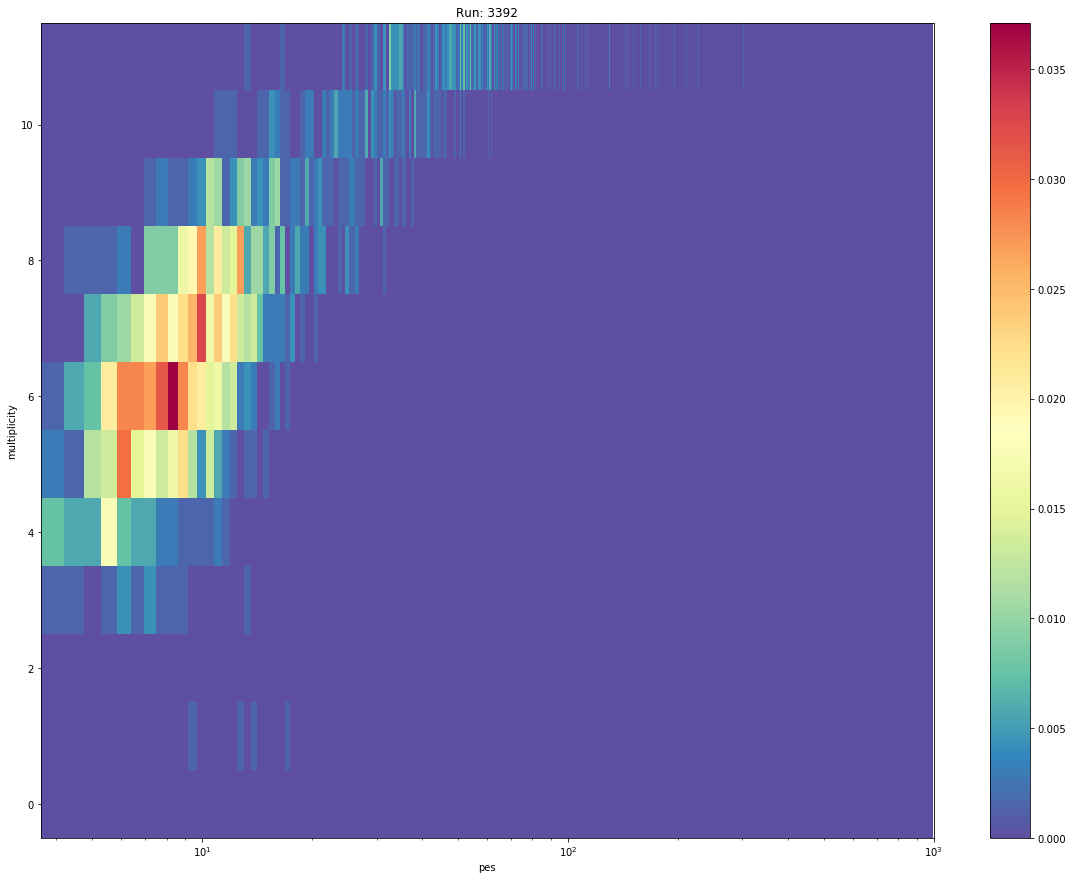

In [22]:
plot_mult_heatmap(energies, multiplicity.sum(axis=1))

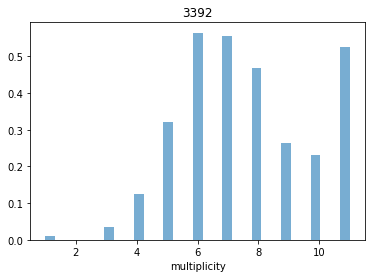

In [25]:
plt.hist(multiplicity.sum(axis=1), bins=30 + 1, alpha=0.6, normed=True)
plt.xlabel('multiplicity')
plt.title(str(run_number))
plt.show()

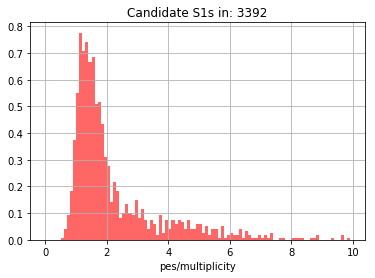

In [28]:
plt.hist(energies/ multiplicity.sum(axis=1), bins=np.arange(0, 10, 0.1), facecolor='red', alpha=0.6, normed=True)
plt.grid(True)
plt.xlabel('pes/multiplicity')
plt.title('Candidate S1s in: ' + str(run_number))
plt.show()